# Exploring photon heights with ICESat-2 (ATL03)

Information obtained primarily from the ATL03 Algorithm Theoretical Basis Document (ATBD, Neumann et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl03.   

* Notebook author: Alek Petty (relying extensively on the ATBD and product description)    
* Description: Notebook describing the ICESat-2 ATL03 product.   
* Input requirements: Any example ATL03 data file.   
* Date: June 2019
* More info: See the ATL03 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03_ATBD_r001.pdf and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL03_Known_Issues_May2019.pdf

## Notebook objectives
* General understanding of the data included in a typical ATL03 file.
* Reading in, plotting and basic analysis of ATL03 data.
* What we can learn from ATL03 to derive the ATL07 surface height segments!


## Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the HDF5 ATL03 file (ATL03_20181115022655_07250104_001_01.h5) obtained from: https://nsidc.org/data/atl03. See the NSIDC tutorial for more information on generating granules of data to use in this tutorial. If using this using the ICESat-2 Pangeo instance, you can download the file from Amazon S3 using the notebook cell provided below.


## ATL03 Background

*NB: This is my laymans description of ATL03 compiled from the above resources, trying to condense this information to the key points of interest to potential sea ice users. let me know if you see any errors!*

ATL03 is a Level 2A ICESat-2 data product available from the NSIDC: https://nsidc.org/data/atl03. It's assumed that ATL03 will be the lowest level product of interest to sea ice users of ICESat-2 data. ATL03 is based on the ICESat-2 Level 1B data product (ATL02) which provides the precise round-trip time of flight of individual photons.  ATL03 combines this information with the  the observatory position and the laser pointing vectors to estimate the location of the photon surface returns relative to the WGS-84 ellipsoid. The ATL03 product is then used by the higher level (Level 3) products that provide more focussed geophysical datasets to respective user communities (e.g. ATL07 below for sea ice).

The data within a given ATL03 fie includes individual photons heights, background rates, and corrections applied to the height estimates. ATL03 applies multiple geophysical corrections to the height estimates to generate a best estimate of the photon height. 

Additional corrections that some users may decide to apply are provided within the product. A number of meteorological parameters (e.g., wind, surface air temperature, sea level pressure, etc. from reanalyses) are also provided with ATL03. ATL03 files are big (serveral hundreds of Gbs for a given granule, hence the desire to produce and release higher level processed products to the community).

ATL03 provides a coarse surface classification to enable higher-level products to easily grab the photons of interest from a given granule (land, ocean, sea ice, land ice, and inland water areas, multiple categories permitted).  

The product also attempts to discriminate between signal (surface returns) and background photon events. The background photons are mainly a result of solar photons at the same frequency of the ATLAS detector (532 nm) that have scattered from clouds or the surface. The background is thus expected to drop to near-zero during nighttime. A background photon rate is calculated by expanding the vertical range of photon detection to over 10 km for more than 400 transmitted laser pulses from the strong beams. Form this expected background rate, a photon rate threhold is set to search for signal photons within vertical elevation bins. The photons are classified for the given surface type classification based on the signal-to-noise ratio: high-confidence signal (SNR > 100), medium-confidence signal (100 > SNR > 40), low confidence signal (40 > SNR > 3), or likely background (SNR < 3).  

Finally, several geophysical corrections are applied to these WGS84 relative heights, including:
* the height of the ocean pole tide
* the height of the ocean load tide
* the height of the solid earth pole tide
* the solid earth tide
* the height of the total column atmospheric delay correction.  

The data product also includes (but doesn't use) the geoid (EGM2008), the ocean tide (GOT4.8) and the AVISO dynamic atmospheric correction (MOG2D) which are often used by the higher level products like ATL07.

Below is an example of how one can read in and explore a given ATL03 file. Very open to suggestions on possible improvements!

In [1]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#import seaborn as sns
import h5py  
import s3fs
import readers as rd
import utils as ut
# Use seaborn for nicer looking inline plots
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")

#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

In [3]:
beamStr='gt1r'

#### Data selection    
If running on Pangeo instance you can greab data directly from Amazon S3 like so
Comment out the last command if you've already got the data in the Data dir

In [4]:
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
s3List = fs.ls(dataDir)
print(s3List)
ATL03file='ATL03_20181115022655_07250104_001_01.h5'
s3File='pangeo-data-upload-oregon/icesat2/'+ATL03file
localFilePath='../Data/'+ATL03file

#fs.get(s3File, localFilePath)
localFilePath

['pangeo-data-upload-oregon/icesat2/ATL03_20181115022655_07250104_001_01.h5', 'pangeo-data-upload-oregon/icesat2/ATL07-01_20181115003141_07240101_001_01.h5', 'pangeo-data-upload-oregon/icesat2/ATL10-01_20181115003141_07240101_001_01.h5', 'pangeo-data-upload-oregon/icesat2/readme.txt', 'pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial', 'pangeo-data-upload-oregon/icesat2/Floes-are-Swell', 'pangeo-data-upload-oregon/icesat2/Snowblower', 'pangeo-data-upload-oregon/icesat2/atl03', 'pangeo-data-upload-oregon/icesat2/atl06', 'pangeo-data-upload-oregon/icesat2/atl10', 'pangeo-data-upload-oregon/icesat2/atl12', 'pangeo-data-upload-oregon/icesat2/data-access-outputs', 'pangeo-data-upload-oregon/icesat2/data-access-shapefile', 'pangeo-data-upload-oregon/icesat2/data-access-subsetted-outputs', 'pangeo-data-upload-oregon/icesat2/data-access-subsettedoutputs', 'pangeo-data-upload-oregon/icesat2/data-correction', 'pangeo-data-upload-oregon/icesat2/elevation_change_tutorial', 'pangeo-d

'../Data/ATL03_20181115022655_07250104_001_01.h5'

In [5]:
# If data file is stored locally (already grabbed from S3) uncomment the following lines and comment out the below S3 example..
#file_path = '../Data/'
#ATL03_filename = 'ATL03_20181115022655_07250104_001_01.h5'
#localPath = file_path + ATL03_filename

NameError: name 'file_path' is not defined

In [7]:
def getATL03data(fileT, numpyout=False, beam='gt1l'):
    """ Pandas/numpy ATL03 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

    I've picked out the variables from ATL03 I think are of most interest to sea ice users, but by no
    means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL03 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you
    might want
    
    Args:
        fileT (str): File path of the ATL03 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beam (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        
    returns:
        either: select numpy arrays or a pandas dataframe

    """
    
    # Open the file
    try:
        ATL03 = h5py.File(fileT, 'r')
    except:
        'Not a valid file'
        
    lons=ATL03[beam+'/heights/lon_ph'][:]
    lats=ATL03[beam+'/heights/lat_ph'][:]
    
    #  Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL03[beam+'/heights/delta_time'][:] 
    
    # #Add this value to delta time parameters to compute the full gps_seconds
    atlas_epoch=ATL03['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    # This function seems pretty convoluted but it works for now..
    # Sure there is a simpler functionw e can use here instead.
    temp = ut.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)
    
    # Express delta_time relative to start time of granule
    delta_time_granule=delta_time-delta_time[0]

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')
    
    dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
                        'hour':hour, 'minute':minute, 'second':second})
    
    
    # Primary variables of interest
    
    # Photon height
    heights=ATL03[beam+'/heights/h_ph'][:]
    print(heights.shape)
    
    # Flag for signal confidence
    # column index:  0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    # values:
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
    signal_confidence=ATL03[beam+'/heights/signal_conf_ph'][:,2] 
    
    # Add photon rate, background rate etc to the reader here if we want
    
    ATL03.close()
    
    
    
    dF = pd.DataFrame({'heights':heights, 'lons':lons, 'lats':lats,
                       'signal_confidence':signal_confidence, 
                       'delta_time':delta_time_granule})
    
    # Add the datetime string
    dFtimepd=pd.to_datetime(dFtime)
    dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
    
    # Filter out high elevation values 
    #dF = dF[(dF['signal_confidence']>2)]
    # Reset row indexing
    #dF=dF.reset_index(drop=True)
    return dF
    
    # Or return as numpy arrays 
    # return along_track_distance, heights

    

#### Read in the data using the pandas reader above. Copied from the readers.py script.

Take a look at the top few rows (change the number in head to increase this..)


In [9]:
dF03= getATL03data(localFilePath, beamStr)
dF03.tail(5)

# Other readers available in readers.py script

(4699046,)


heights      lons       lats  signal_confidence  delta_time  \
4699041  938.400330  4.483219  79.994307                  4  309.159707   
4699042  942.420593  4.483201  79.994295                  4  309.159907   
4699043  944.992249  4.483200  79.994295                  4  309.159907   
4699044  951.123047  4.483134  79.994245                  4  309.160707   
4699045  933.075745  4.483064  79.994183                  4  309.161707   

                   datetime  
4699041 2018-11-15 02:32:04  
4699042 2018-11-15 02:32:04  
4699043 2018-11-15 02:32:04  
4699044 2018-11-15 02:32:04  
4699045 2018-11-15 02:32:04

#### Map the data for visual inspection using Cartopy 
*NB (Basemap is often used for mapping but is not being officially supported by the community anymore)*


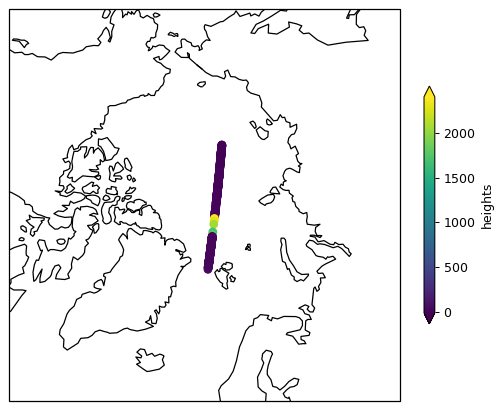

In [10]:
# Generate a shorted version for mapping purposes
dF03short=dF03.iloc[::10000, :]
dF03short.head(5)

var='heights'

plt.figure(figsize=(7,7), dpi= 90)
# Make a new "NorthPolarStereo" projection instance
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF03short['lons'], dF03short['lats'],c=dF03short[var], cmap='viridis', transform=ccrs.PlateCarree())

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

#### Plot the photon heights of this section
*NB: Could use seaborn for this (for one line plots) but using matplotlib for increased user flexibility.*


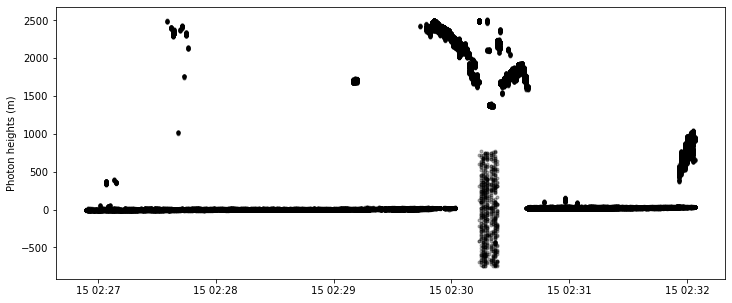

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(dF03['datetime'],dF03['heights'], color='k', marker='.', linestyle='None', alpha=0.3)
#plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()

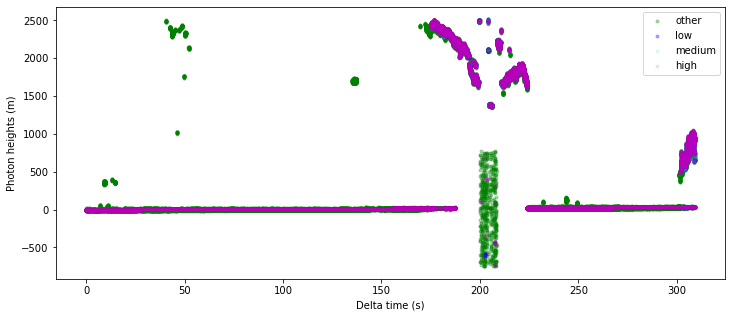

In [12]:
# Plot the photon heights but now use the signal confidence to label the markers.

#np.size(np.where(dF03['signal_confidence']==3))
plt.figure(figsize=(12, 5))
plt.plot(dF03[(dF03['signal_confidence']<2)]['delta_time'],dF03[(dF03['signal_confidence']<2)]['heights'], label='other', color='g', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03[(dF03['signal_confidence']==2)]['delta_time'],dF03[(dF03['signal_confidence']==2)]['heights'], label='low', color='b', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03[(dF03['signal_confidence']==3)]['delta_time'],dF03[(dF03['signal_confidence']==3)]['heights'], label='medium', color='c', marker='.', linestyle='None', alpha=0.1)
plt.plot(dF03[(dF03['signal_confidence']==4)]['delta_time'],dF03[(dF03['signal_confidence']==4)]['heights'], label='high', color='m', marker='.', linestyle='None', alpha=0.1)
plt.legend(loc=1)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()

# Another (more elegant but less flexible) of doing a plot like this is using seaborn...
#plt.figure(figsize=(12, 5))
#sns.pairplot(x_vars=["delta_time"], y_vars=["heights"], data=dF03, 
#hue="signal_confidence", size=5)
#plt.gca().set_ylim((0, 50000))

#### Let's do some basic filtering of the data! 
*Note that for sea ice our task is easier than land ice, as we know our returns should be coming from a narrow window around sea level*

In [13]:
# Now let's only keep the high confidence photons
dF03ice = dF03[(dF03['signal_confidence']>3)]

# ...and let's apply a hight window around the surface (+/- 50 m)
dF03ice = dF03ice[(abs(dF03ice['heights'])<50)]

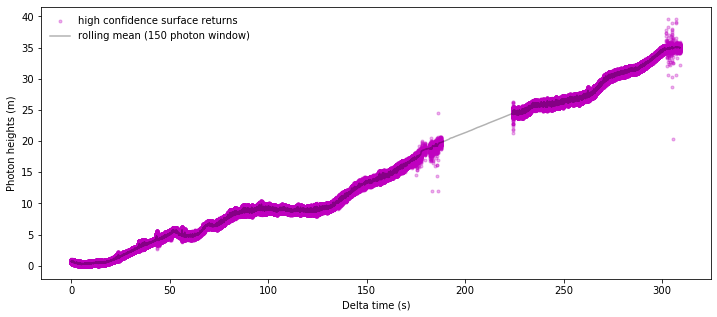

In [14]:
# Plot the data like before
plt.figure(figsize=(12, 5))
plt.plot(dF03ice['delta_time'],dF03ice['heights'], label='high confidence surface returns', color='m', marker='.', linestyle='None', alpha=0.3)
# plot a rolling mean of the photon heights. 150 photons is used in the generation of ATL07
plt.plot(dF03ice['delta_time'].rolling(150).mean(),dF03ice['heights'].rolling(150).mean(), label='rolling mean (150 photon window)', color='k', linestyle='-', alpha=0.3)
plt.legend(loc=2, frameon=False)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()

### We now need to make extra corrections to the data not included in ATL03 (ocean tides, geoid, DAC?)



### Extra ideas

1. Check out the surface classification (check it's all sea ice or open water?!)
2. Play around removing the corrections and see what that does to the heights.
3. ?

### Onwards to the ATL07 Notebook...!